In [3]:
PATH <- file.path("C:/Users/julia/OneDrive - London School of Hygiene and Tropical Medicine/Documents/LSHTM/Project") #"/home/andewegs/1_RSV_scripts/"
setwd(PATH)
#getwd()
library(tidyverse)
rsv.data <- read_csv(file = "Data/infection_status.csv")

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.6     v purrr   0.3.4
v tibble  3.1.7     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Rows: 682 Columns: 23
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
dbl  (20): age_days, infection, IgG_PreF, IgA_PreF, IgG_PostF, IgA_PostF, Ig...
lgl   (1): IgA_Nn_household
date  (2): birthday, consultdate

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
#get true number of infected and recovered children
rsv_by_age <- rsv.data %>% arrange(age_days)
tab <- table(rsv_by_age$age_days, rsv_by_age$infection)
true_hist <- data.frame(age=rownames(tab), infected=tab[,2])
true_hist$age <- as.numeric(true_hist$age)
true_hist$cuminfection <- cumsum(true_hist$infected)
tail(true_hist)

,age,infected,cuminfection
,<dbl>,<int>,<int>
1808,1808,1,339
1821,1821,1,340
1823,1823,1,341
1841,1841,2,343
1843,1843,1,344
1854,1854,1,345


In [5]:
#add susceptible
N <- nrow(rsv_by_age)
true_hist$susceptible <- N - true_hist$cuminfection
tail(true_hist)

,age,infected,cuminfection,susceptible
,<dbl>,<int>,<int>,<int>
1808,1808,1,339,343
1821,1821,1,340,342
1823,1823,1,341,341
1841,1841,2,343,339
1843,1843,1,344,338
1854,1854,1,345,337


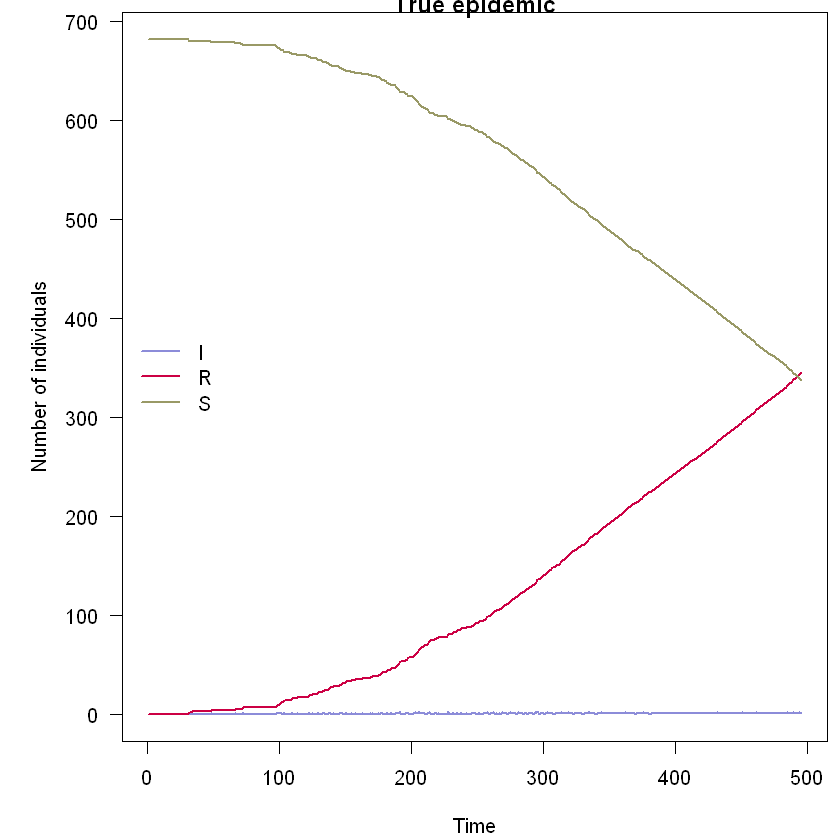

In [6]:
#png("true epidemic.png")
cols <- names(true_hist) %in% c('age')
hist_no_time <- true_hist[!cols]
par(mar = c(4.1, 5.1, 0.5, 0.5), las = 1)
cols <- c(I = "#8c8cd9", R = "#cc0044", S = "#999966")
matplot(hist_no_time, type = "l", 
        xlab = "Time", ylab = "Number of individuals",
        col = cols, lty = 1, lwd = 2)
legend("left", lwd = 2, col = cols, legend = names(cols), bty = "n")
title("True epidemic", line = 0)
#dev.off()

In [61]:
#build a true history with all days
min = head(true_hist$age,1)
max = tail(true_hist$age,1)
days <- seq(min, max)
infected <- rep(0, max-min+1)
susceptible <- rep(0, max-min+1)
recovered <- rep(0, max-min+1)

true_hist_all <- data.frame(days, susceptible,infected, recovered)

In [63]:
for (d in seq_along(true_hist_all$days)){
    for (a in seq_along(true_hist$age)){
     if (true_hist_all$days[d] == true_hist$age[a]){
         true_hist_all$susceptible[d] <- true_hist$susceptible[a]
         true_hist_all$infected[d] <- true_hist$infected[a]
         true_hist_all$recovered[d] <- true_hist$cuminfection[a]
     }
   }
}

In [66]:
for (d in seq_along(true_hist_all$days)){
     if (true_hist_all$susceptible[d] == 0){
         true_hist_all$susceptible[d] <- true_hist_all$susceptible[d-1]
     }
}

In [71]:
N = nrow(rsv_by_age)
true_hist_all$recovered <- N - true_hist_all$susceptible - true_hist_all$infected

In [72]:
true_hist_all

days,susceptible,infected,recovered
<int>,<dbl>,<dbl>,<dbl>
36,682,0,0
37,682,0,0
38,682,0,0
39,682,0,0
40,682,0,0
41,682,0,0
42,682,0,0
43,682,0,0
44,682,0,0


Now mcstate

In [7]:
rsv_by_age <- rsv.data %>% arrange(age_days)
tab <- table(rsv_by_age$age_days, rsv_by_age$infection)
dframe <- data.frame(age=rownames(tab), infected=tab[,2])
dframe$age <- as.numeric(dframe$age)
dframe$cuminfection <- cumsum(dframe$infected)

In [6]:
tail(dframe)

,age,infected,cuminfection
,<dbl>,<int>,<int>
1808,1808,1,339
1821,1821,1,340
1823,1823,1,341
1841,1841,2,343
1843,1843,1,344
1854,1854,1,345


In [9]:
#get only participants aged 97 days or more
dframe2 <- subset(dframe, age>=97)

In [10]:
#define a dataframe with all days between the youngest age and the oldest age
min = head(dframe2$age,1)
max = tail(dframe2$age,1)
days <- seq(min, max)
infections <- rep(0, max-min+1)

df <- data.frame(days, infections)

In [11]:
for (d in seq_along(df$days))
    for (a in seq_along(dframe2$age))
     if (df$days[d] == dframe2$age[a])
         df$infections[d] <- dframe2$infected[a]

In [12]:
dt <- 1
sir_data <- mcstate::particle_filter_data(data = df,
                                          time = "days",
                                          rate = 1 / dt)
head(rmarkdown::paged_table(sir_data))

,days_start,days_end,step_start,step_end,infections
,<int>,<int>,<int>,<int>,<dbl>
1,96,97,96,97,2
2,97,98,97,98,0
3,98,99,98,99,0
4,99,100,99,100,0
5,100,101,100,101,0
6,101,102,101,102,1


In [13]:
case_compare <- function(state, observed, pars = NULL) {
  exp_noise <- 1e6

  incidence_modelled <- state[4 , drop = TRUE]
  incidence_observed <- observed$infections
  lambda <- incidence_modelled +
    rexp(n = length(incidence_modelled), rate = exp_noise)
  dpois(x = incidence_observed, lambda = lambda, log = TRUE)
}

In [14]:
incidence_compare <- function(state, prev_state, observed, pars = NULL) {
  exp_noise <- 1e6

  lambda <- state[4, , drop = TRUE] +
    rexp(n = length(incidence_modelled), rate = exp_noise)
  dpois(x = observed$infections, lambda = lambda, log = TRUE)
}

In [12]:
nrow(rsv_by_age)

[1] 682

In [15]:

setwd("C:/Users/julia")
getwd()

[1] "C:/Users/julia"

In [2]:
#model with S = 682
library(odin.dust)
gen_sir <- odin.dust::odin_dust("sir.R")
sir_model <- gen_sir$new(pars = list(dt = 1,
                                     S_ini = 681,
                                     I_ini = 1,
                                     beta = 0.2,
                                     gamma = 0.1),
                         step = 1,
                         n_particles = 10L,
                         n_threads = 4L,
                         seed = 1L)

Loading required namespace: pkgbuild

i 18 functions decorated with [[cpp11::register]]

v generated file cpp11.R

v generated file cpp11.cpp

Re-compiling sir77a075f7



-  installing *source* package 'sir77a075f7' ... (459ms)
   ** using staged installation
   ** libs
   g++  -std=gnu++11 -I"C:/Users/julia/anaconda3/lib/R/include" -DNDEBUG  -I'C:/Users/julia/anaconda3/Lib/R/library/cpp11/include'     -IC:/Users/julia/anaconda3/Lib/R/library/dust/include -DHAVE_INLINE -fopenmp   -O2 -Wall  -march=x86-64 -mtune=generic  -Wall -pedantic -c cpp11.cpp -o cpp11.o
   g++  -std=gnu++11 -I"C:/Users/julia/anaconda3/lib/R/include" -DNDEBUG  -I'C:/Users/julia/anaconda3/Lib/R/library/cpp11/include'     -IC:/Users/julia/anaconda3/Lib/R/library/dust/include -DHAVE_INLINE -fopenmp   -O2 -Wall  -march=x86-64 -mtune=generic  -Wall -pedantic -c dust.cpp -o dust.o
   dust.cpp: In function 'cpp11::sexp dust::dust_info(const dust::pars_type<T>&) [with T = sir]':
   dust.cpp:298:28: warning: variable 'internal' set but not used [-Wunused-but-set-variable]
     298 |   const sir::internal_type internal = pars.internal;
         |                            ^~~~~~~~
   g++ -s

i Loading sir77a075f7



In [16]:
sir_model$n_particles()

[1] 10

In [19]:
n_particles <- 1L
filter <- mcstate::particle_filter$new(data = sir_data,
                                       model = gen_sir,
                                       n_particles = n_particles,
                                       compare = case_compare,
                                       seed = 1L)

In [20]:
filter$run(save_history = TRUE, pars = list(dt = dt))

[1] -1388970

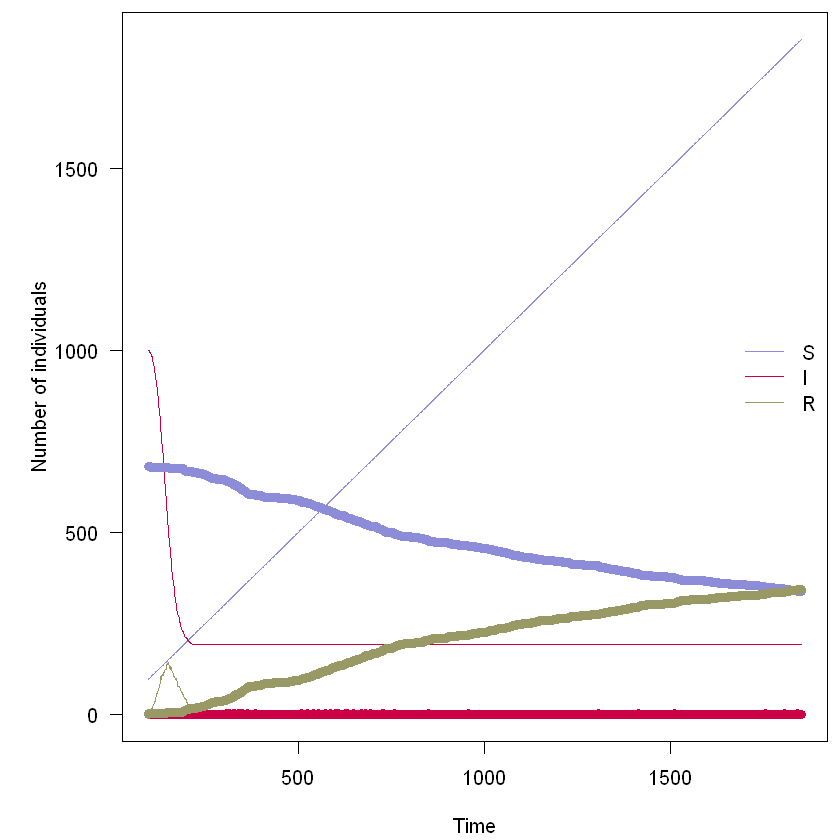

In [118]:
plot_particle_filter <- function(history, true_history, times, obs_end = NULL) {
  if (is.null(obs_end)) {
    obs_end <- max(times)
  }

  par(mar = c(4.1, 5.1, 0.5, 0.5), las = 1)
  cols <- c(S = "#8c8cd9", I = "#cc0044", R = "#999966")
  matplot(times, (history[1, , -1]), type = "l",
          xlab = "Time", ylab = "Number of individuals",
          col = cols[["S"]], lty = 1, ylim = range(history))
  matlines(times, (history[2, , -1]), col = cols[["I"]], lty = 1)
  matlines(times, (history[3, , -1]), col = cols[["R"]], lty = 1)
  matpoints(t(times), t(true_history[,2, -1]), pch = 19,col = cols["S"])
  matpoints(t(times), t(true_history[,3, -1]), pch = 19,col = cols["I"])
  matpoints(t(times), t(true_history[,4, -1]), pch = 19,col = cols["R"])
  legend("right", lwd = 1, col = cols, legend = names(cols), bty = "n")
}

true_history <- subset(true_hist_all, days>=97)
plot_particle_filter(filter$history(), true_history, df$days)